# Transfer Learning



In [1]:
import torch
import numpy as np
from torchvision import datasets, models, transforms
import torchvision
import matplotlib.pyplot as plt
import time
import os
import seaborn as sn
import pandas as pd
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


In [2]:
# we do not have gpu on colab
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Prepare Image Data

I need to skip every 100 frames becuase they are essentially the same picture with 1 second apart. This is the reason we have a 100% accuracy. Basically we are learning and testing on the same set of images and the variaty is quiet low. You can see this after skipping every 100 frames. The images still look alike. 

In [3]:
import os

grades = ['S00', 'S05', 'S10', 'S20', 'S30', 'S40']
folder_name = "mixture_total"

# Check if the folder 'mixture' exists, if not, create it
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Create subfolders for each grade
for grade in grades:
    subfolder_path = os.path.join(folder_name, grade)
    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)
        print(f"Subfolder '{grade}' created in '{folder_name}' folder.")
    else:
        print(f"Subfolder '{grade}' already exists in '{folder_name}' folder.")


Subfolder 'S00' already exists in 'mixture_total' folder.
Subfolder 'S05' already exists in 'mixture_total' folder.
Subfolder 'S10' already exists in 'mixture_total' folder.
Subfolder 'S20' already exists in 'mixture_total' folder.
Subfolder 'S30' already exists in 'mixture_total' folder.
Subfolder 'S40' already exists in 'mixture_total' folder.


In [4]:
first_folder = 'RANDOM_PICTURES_TO_VERIFY (1)/RANDOM_PICTURES_TO_VERIFY/'


In [5]:
first_folder = 'P02_PLF_Bunk_Score_Classes_Pictures-20240308T171042Z-001/P02_PLF_Bunk_Score_Classes_Pictures/'
destination='mixture_total/'


In [6]:
import shutil


In [ ]:

for name in os.listdir(first_folder):
    for grade in grades:
        if grade in name:
    
            source_folder = os.path.join(first_folder,name)
            destination_folder = os.path.join(destination, grade)
            # shutil.copyfile(source_path, destination_path)

            print(source_folder,'*'*10,destination_folder)
            count=0
            for image_file in os.listdir(source_folder):
                count+=1
                if count % 10 == 0:
                    source_path = os.path.join(source_folder, image_file)
                    destination_path = os.path.join(destination_folder, image_file)
                    shutil.copyfile(source_path, destination_path)

In [8]:
grade

'S40'

In [36]:
images[0][0].shape

torch.Size([3, 224, 224])

### Image Transformation

I added some brightness augmentation so the model can handle different time of the day.

In [9]:
# this is the mean and standard deviation for imagenet dataset
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

transform = transforms.Compose([
        transforms.ColorJitter(brightness=(0.5, 1.5)),  # Adjust brightness
        transforms.Resize((224,224)),
#         transforms.CenterCrop((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

### Image Dataloader

In [10]:
images = datasets.ImageFolder('mixture/',transform)

### Data Split for Training, Validation, and Testing

In [11]:
data_size = len(images.imgs)
train_size = int(data_size*0.8)
val_size = (data_size-train_size)//2
test_size = data_size-train_size-val_size
train_set, val_set, test_set = data.random_split(images, (train_size,val_size,test_size))


In [12]:
train_size,test_size,val_size

(146, 19, 18)

In [13]:
# images

In [14]:

batch_size=16
class_names = images.classes

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=1)


### visualize the input examples

torch.Size([224, 224])
tensor([5, 5, 4, 1, 1, 5, 1, 1, 2, 4, 4, 0, 1, 4, 4, 3])


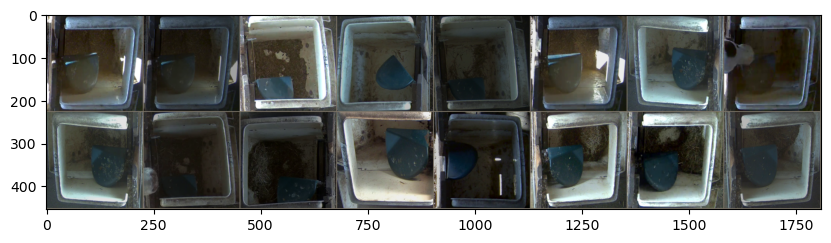

In [15]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean # correct the nornalization
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

# Get a batch of training data
inputs, classes = next(iter(train_dataloader))
print(inputs[0][0].shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(10,5))
imshow(out, title='Input Examples')
print(classes)

In [16]:
test_set[0][0].shape

torch.Size([3, 224, 224])

### Result Visualization

In [17]:
def visualize_model(model, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(20,20))
    sm = torch.nn.Softmax()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            l=labels
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            confidence = np.amax(np.array(sm(outputs.cpu())),1)
#             break
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//4, 4, images_so_far)
                ax.set_xlabel('Groun Truth: {}'.format(class_names[l[j]]))
                ax.set_ylabel('Prediction: {}'.format(class_names[preds[j]]))
                ax.set_title('Confidence {:.2f}'.format(confidence[j]))

                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))

                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                ax.imshow(inp)
                if images_so_far == num_images:
                    return


## Train a Model with Pretrained Weights

In [18]:
from torch.optim import lr_scheduler

model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
# The last layer should have len(class_names neruons)
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

C:\Users\piyalong\AppData\Local\anaconda3\envs\jupyterlab\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\piyalong\AppData\Local\anaconda3\envs\jupyterlab\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
since = time.time()

best_acc = 0.0
num_epochs=20

for epoch in range(num_epochs):
    print('-' * 10)

    model.train()  # Set model to training mode
    train_running_loss = 0.0
    train_running_corrects = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # backward + optimize only if in training phase
        loss.backward()
        optimizer.step()

        # statistics
        train_running_loss += loss.item() * inputs.size(0)
        train_running_corrects += torch.sum(preds == labels.data)
    scheduler.step()

    train_epoch_loss = train_running_loss / len(train_set)
    train_accuracy = train_running_corrects.double() / len(train_set)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")


    # Each epoch has a validation phase

    model.eval()   # Set model to evaluate mode
    val_running_loss = 0.0
    val_running_corrects = 0

    # Iterate over data.
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # statistics
        val_running_loss += loss.item() * inputs.size(0)
        val_running_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_running_loss / len(val_set)
    val_accuracy = val_running_corrects.double() / len(val_set)
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_epoch_loss:.4f}, validation Accuracy: {val_accuracy:.2f}%")

        # deep copy the model
    if  val_accuracy > best_acc:
        best_acc = val_accuracy
        best_model = model.state_dict()
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))


----------
Epoch 1/20, Training Loss: 1.5365, Training Accuracy: 0.38%
Epoch 1/20, Validation Loss: 1.2842, validation Accuracy: 0.56%
----------
Epoch 2/20, Training Loss: 0.8146, Training Accuracy: 0.77%
Epoch 2/20, Validation Loss: 0.8704, validation Accuracy: 0.72%
----------
Epoch 3/20, Training Loss: 0.4384, Training Accuracy: 0.89%
Epoch 3/20, Validation Loss: 0.6976, validation Accuracy: 0.78%
----------
Epoch 4/20, Training Loss: 0.3317, Training Accuracy: 0.89%
Epoch 4/20, Validation Loss: 0.7348, validation Accuracy: 0.72%
----------
Epoch 5/20, Training Loss: 0.2148, Training Accuracy: 0.99%
Epoch 5/20, Validation Loss: 0.6302, validation Accuracy: 0.72%
----------
Epoch 6/20, Training Loss: 0.1443, Training Accuracy: 0.98%
Epoch 6/20, Validation Loss: 0.5073, validation Accuracy: 0.83%
----------
Epoch 7/20, Training Loss: 0.1817, Training Accuracy: 0.97%
Epoch 7/20, Validation Loss: 0.6651, validation Accuracy: 0.83%
----------
Epoch 8/20, Training Loss: 0.1416, Training 

### Saving the Best Model and Load

In [20]:
torch.save(best_model, 'best_model.pth')

This is testing on the testing portion, which is from the same mixture. The best testing accuracy is 88.99% above. 

In [21]:
model = models.resnet18(pretrained=False)

num_ftrs = model.fc.in_features
# The last layer should have len(class_names neruons)
model.fc = nn.Linear(num_ftrs, len(class_names))

model.load_state_dict(torch.load('best_model.pth'))
model.to(device);

C:\Users\piyalong\AppData\Local\anaconda3\envs\jupyterlab\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


C:\Users\piyalong\AppData\Local\Temp\ipykernel_26560\4122612502.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  confidence = np.amax(np.array(sm(outputs.cpu())),1)


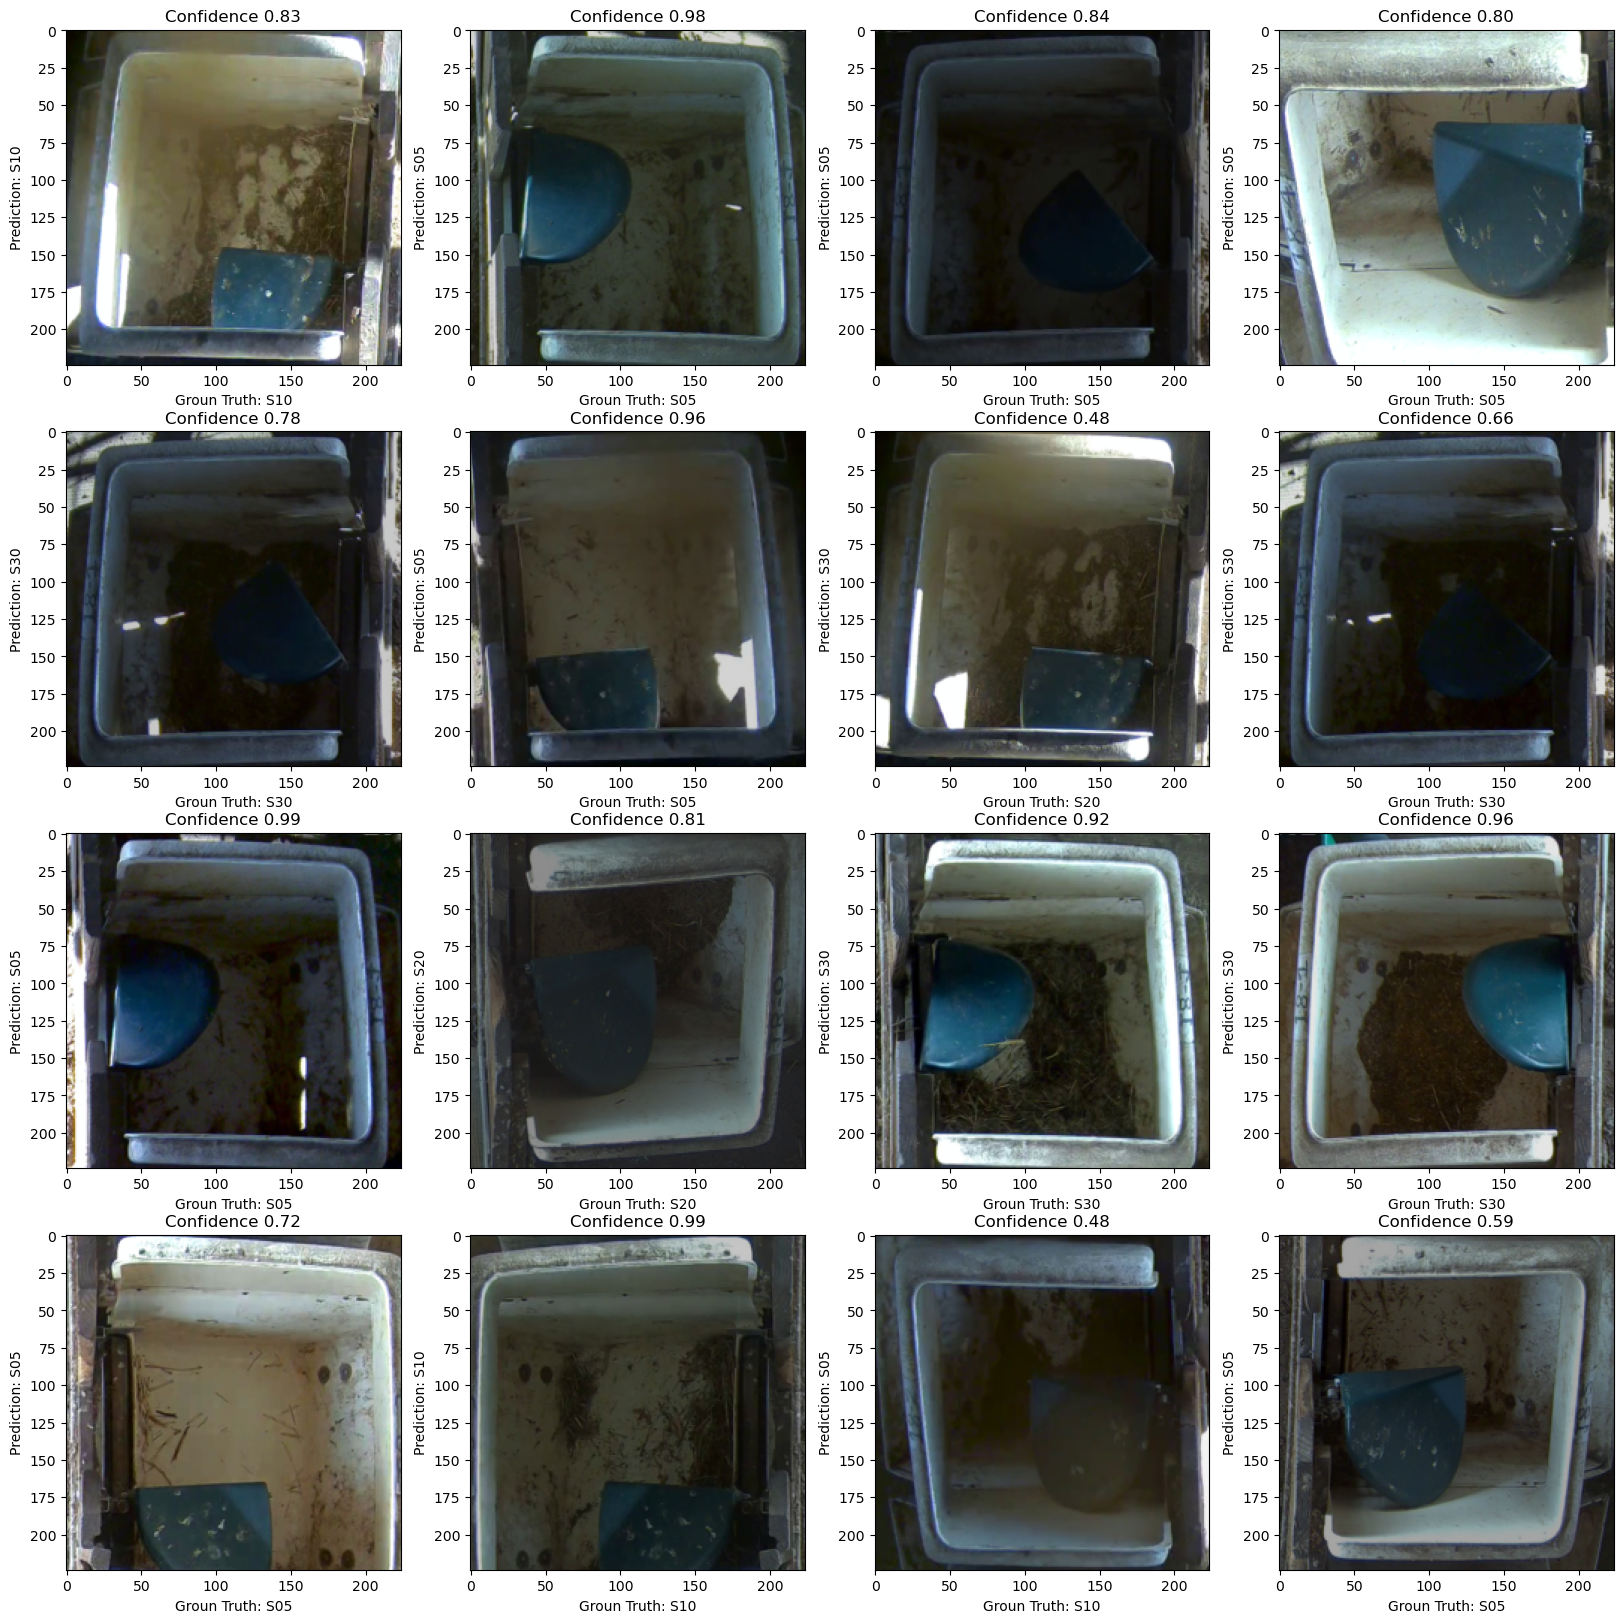

In [22]:
visualize_model(model)

Now we make the test dataloader to load the random selected pictures and get the confusion matrix. We can see the model works for the random selected pictures. The key for next steps is to get diverse training dataset to cover many different conditions. This also can be done by data augmentation. 

In [23]:
test_set = datasets.ImageFolder('RANDOM_PICTURES_TO_VERIFY (1)/RANDOM_PICTURES_TO_VERIFY/',transform)


In [24]:
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)


## Confusion Matrix Result Analysis

In [25]:
nb_classes = len(class_names)

confusion_matrix = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():

    for i, (inputs, classes) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[9.0600e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 3.1880e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [3.0000e+01, 1.2900e+02, 1.1570e+03, 0.0000e+00, 6.0000e+00, 1.6000e+01],
        [0.0000e+00, 1.5000e+01, 1.0100e+02, 4.7800e+02, 8.8000e+01, 0.0000e+00],
        [0.0000e+00, 4.0000e+00, 4.4000e+01, 0.0000e+00, 1.1750e+03, 3.0000e+01],
        [0.0000e+00, 9.0000e+00, 0.0000e+00, 0.0000e+00, 7.3000e+01, 4.5500e+02]])


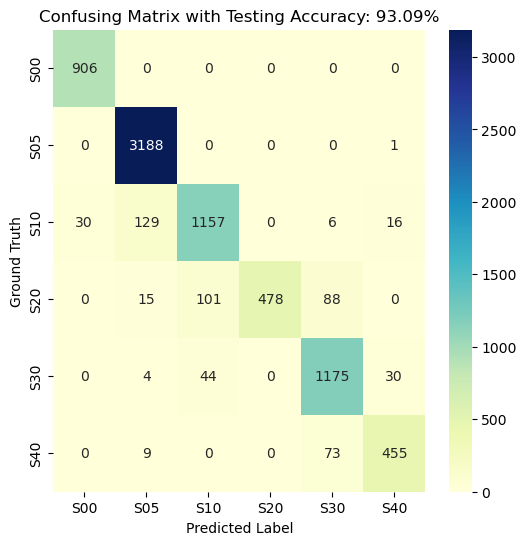

In [26]:
df_cm = pd.DataFrame(confusion_matrix.numpy().astype('int'), index = [i for i in class_names],
                  columns = [i for i in class_names])

test_acc=np.trace(confusion_matrix.numpy().astype('int'))/np.sum(np.sum(df_cm))

plt.figure(figsize = (len(class_names),len(class_names)))
plt.title('Confusing Matrix with Testing Accuracy: {:0.2f}%'.format(test_acc*100))

sn.heatmap(df_cm, annot=True,fmt='g',cmap="YlGnBu")
plt.xlabel('Predicted Label')
plt.ylabel('Ground Truth')
plt.savefig('Confusing Matrix.pdf',dpi=300)

In [27]:
cm=confusion_matrix.numpy().astype('int')
recall = np.diag(cm) /( np.sum(cm, axis = 1)+0.000000001)
precision = np.diag(cm) /( np.sum(cm, axis = 0)+0.000000001)
f1_per_class = 2 * (precision * recall) / (precision + recall)

data = {'Class': images.classes, 'Precision': precision, 'Recall': recall, 'F1': f1_per_class}
df = pd.DataFrame(data)

styled_df = df.style.format({'Precision': '{:.2%}', 'Recall': '{:.2%}','F1': '{:.2%}'})

print(styled_df)

# Save the DataFrame to a CSV file
df.to_csv('precision_recall_table.csv', index=False)

In [28]:
len(test_set)

7905

In [29]:

f1_per_class

array([0.98371336, 0.97581879, 0.87651515, 0.82413793, 0.90558767,
       0.87584216])

In [30]:
df

,Class,Precision,Recall,F1
0,S00,0.967949,1.000000,0.983713
1,S05,0.953064,0.999686,0.975819
2,S10,0.888633,0.864723,0.876515
3,S20,1.000000,0.700880,0.824138
4,S30,0.875559,0.937749,0.905588
5,S40,0.906375,0.847300,0.875842


In [31]:
styled_df = df.style.format({'Precision': '{:.2%}', 'Recall': '{:.2%}','F1': '{:.2%}'})
styled_df

,Class,Precision,Recall,F1
0,S00,96.79%,100.00%,98.37%
1,S05,95.31%,99.97%,97.58%
2,S10,88.86%,86.47%,87.65%
3,S20,100.00%,70.09%,82.41%
4,S30,87.56%,93.77%,90.56%
5,S40,90.64%,84.73%,87.58%


This is a S00


C:\Users\piyalong\AppData\Local\Temp\ipykernel_26560\99363173.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  confidences = np.array(sm(out.cpu()))


Text(0.5, 1.0, 'Confidence for each class')

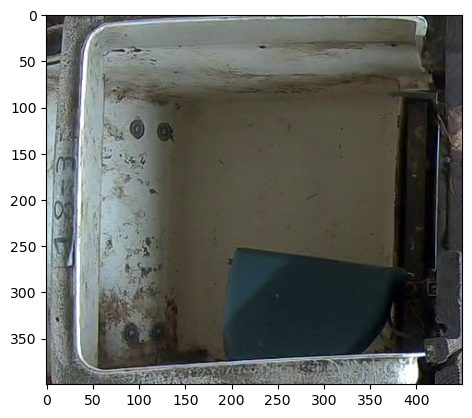

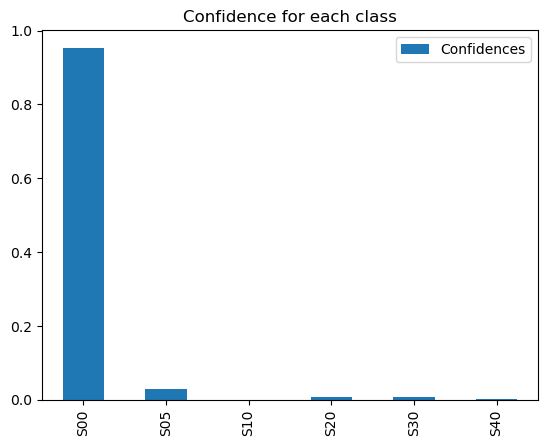

In [38]:
from PIL import Image

image_path = 'RANDOM_PICTURES_TO_VERIFY (1)/RANDOM_PICTURES_TO_VERIFY/S00/FB_03_2023-11-10_NVRCH03-102245-102745_S5.0_141.jpg'

image = Image.open(image_path)
plt.imshow(image)

x = transform(image)
x=x.to(device).unsqueeze(0)

with torch.no_grad():
    model.eval()
    out = model(x)
    _, preds = torch.max(out, 1)

print('This is a {}'.format(class_names[preds]))
sm = torch.nn.Softmax()
confidences = np.array(sm(out.cpu()))
df = pd.DataFrame({'Confidences':confidences[0]},index=class_names)
df.plot.bar()
plt.title('Confidence for each class')